In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
final = pd.read_csv('./Clean/modified_flyball.csv', dtype={'game_state': str})
routes = pd.read_parquet('./Clean/mapped_routes.parquet')
p1_y_m = pickle.load(open('./CLean/p1_y.pkl', 'rb'))
p2_y_m = pickle.load(open('./CLean/p2_y.pkl', 'rb'))


In [3]:
final['p1_y_pred'] = p1_y_m.predict(final[['launch_angle', 'exit_velocity', 'spray_angle', 'field_y']])
final['p2_y_pred'] = p2_y_m.predict(final[['launch_angle', 'exit_velocity', 'spray_angle', 'p1_y_pred']])


In [4]:
def cubic_bezier_curve(df):
    bezier_x = []
    bezier_y = []
    
    p0 = (df['field_x_int'].iloc[0], df['field_y_int'].iloc[0])
    p1 = (df['p1_x'].iloc[0], df['p1_y_pred'].iloc[0])
    p2 = (df['p2_x'].iloc[0], df['p2_y_pred'].iloc[0])
    p3 = (df['field_x_int'].iloc[-1], df['field_y_int'].iloc[-1])

    t_range = np.linspace(0, 1, 100)

    x_p = []
    y_p = []

    for t in t_range:
        x = (1 - t)**3 * p0[0] + 3 * (1 - t)**2 * t * p1[0] + 3 * (1 - t) * t**2 * p2[0] + t**3 * p3[0]
        y = (1 - t)**3 * p0[1] + 3 * (1 - t)**2 * t * p1[1] + 3 * (1 - t) * t**2 * p2[1] + t**3 * p3[1]
        x_p.append(x)
        y_p.append(y)

    bezier_x.extend(x_p)
    bezier_y.extend(y_p)
    
    return bezier_x, bezier_y

def quadratic_bezier_curve(df):
    bezier_x = []
    bezier_y = []
    
    p0 = (df['field_x_int'].iloc[0], df['field_y_int'].iloc[0])
    p1 = (df['p1_x'].iloc[0], df['p1_y_pred'].iloc[0])
    p2 = (df['field_x_int'].iloc[-1], df['field_y_int'].iloc[-1])

    t_range = np.linspace(0, 1, 100)

    x_p = []
    y_p = []

    for t in t_range:
        x = (1 - t)**2 * p0[0] + 2 * (1 - t) * t * p1[0] + t**2 * p2[0]
        y = (1 - t)**2 * p0[1] + 2 * (1 - t) * t * p1[1] + t**2 * p2[1]
        x_p.append(x)
        y_p.append(y)

    bezier_x.extend(x_p)
    bezier_y.extend(y_p)
    
    return bezier_x, bezier_y

In [5]:
plot = final.merge(routes[['game_str', 'play_id', 'field_x_int', 'field_y_int', 'linear_x', 'linear_y']], on = ['game_str', 'play_id'], how='left')


Text(0.5, 1.0, 'Predicted route route vs. Actual route')

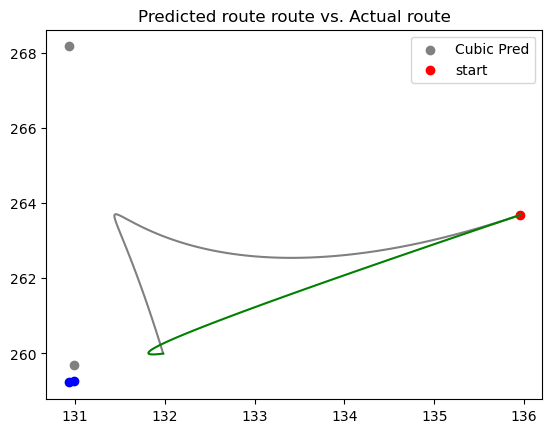

In [6]:
game = '1884_107_Vis3AR_Home3A'
play_id = 43

plot_test = plot.query(f"game_str == '{game}' & play_id == {play_id}")
coords = plot.query(f"game_str == '{game}' & play_id == {play_id}")
cx, cy = cubic_bezier_curve(plot_test)
qx, qy = quadratic_bezier_curve(plot_test)
# plt.plot(plot_test['field_x_int'], plot_test['field_y_int']) # actual line
plt.plot(cx, cy, color = 'grey') # expected line
plt.plot(qx, qy, color = 'green') # expected line
#plt.plot(plot_test['linear_x'], plot_test['linear_y']) # straight line

plt.scatter(coords['p1_x'].iloc[0], coords['p1_y'].iloc[0], c='blue')
plt.scatter(coords['p2_x'].iloc[0], coords['p2_y'].iloc[0], c='blue')
plt.scatter(coords['p1_x'].iloc[0], coords['p1_y_pred'].iloc[0], c='grey', label = 'Cubic Pred')
plt.scatter(coords['p2_x'].iloc[0], coords['p2_y_pred'].iloc[0], c='grey')
plt.scatter(plot_test['field_x_int'].iloc[0], plot_test['field_y_int'].iloc[0], color='r', label = 'start')
plt.legend(loc= 'best')
plt.title('Predicted route route vs. Actual route')
#plt.xlim(-20, 20)

#plt.ylim(0, 400)

In [7]:
values = []
for (game_str, play_id), play in tqdm(plot.groupby(['game_str', 'play_id']), desc = 'Extracting distance'):
    cx, cy = cubic_bezier_curve(play)
    cx_diff = np.diff(np.array(cx))
    cy_diff = np.diff(np.array(cy))
    cstepwise_diff = np.sqrt(cx_diff**2 + cy_diff ** 2)
    cdistance = np.sum(cstepwise_diff)
    
    qx, qy = quadratic_bezier_curve(play)
    qx_diff = np.diff(np.array(qx))
    qy_diff = np.diff(np.array(qy))
    qstepwise_diff = np.sqrt(qx_diff**2 + qy_diff ** 2)
    qdistance = np.sum(qstepwise_diff)
    
    values.append({'game_str': game_str, 'play_id': play_id, 'cubic_expected_distance' : cdistance, 
                  'quadratic_expected_distance' : qdistance})
    

Extracting distance: 100%|████████████████| 4491/4491 [00:01<00:00, 2401.11it/s]


In [8]:
derived = pd.DataFrame(values)

final = final.merge(derived, on = ['game_str', 'play_id'], how = 'left')

In [9]:
final['c_route_efficiency'] = final['cubic_expected_distance'] / final['actual_distance']
final['q_route_efficiency'] = final['quadratic_expected_distance'] / final['actual_distance']

In [10]:
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,max_player_speed,actual_time,league,handedness_encode,p1_y_pred,p2_y_pred,cubic_expected_distance,quadratic_expected_distance,c_route_efficiency,q_route_efficiency
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,18.968681,5.50,Home1A,1,307.340851,319.669586,23.387535,23.279352,0.560463,0.557871
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,18.278859,5.15,Home1A,0,240.415726,215.724991,67.384952,65.828048,0.932447,0.910903
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,12.877761,3.55,Home1A,0,307.367798,276.698273,71.575377,71.458691,0.807418,0.806102
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,12.877761,4.05,Home1A,1,270.413025,288.862885,62.489751,62.457962,0.975942,0.975445
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,18.625452,4.50,Home1A,1,240.020920,264.587097,103.392230,103.200699,0.982500,0.980680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,1,8160659,BA,...,12.154987,3.80,Home4A,0,233.579620,228.573212,82.280565,78.787070,0.952803,0.912349
4490,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,16.983263,5.45,Home4A,1,261.418884,281.564514,63.979744,63.878057,0.920528,0.919065
4491,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,17.721751,5.80,Home4A,1,304.144592,313.857727,55.478833,54.384052,0.987860,0.968366
4492,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,12.154987,3.05,Home4A,1,257.659790,263.371521,46.799652,43.572066,1.025416,0.954697


In [11]:
final.groupby('game_state')[['c_route_efficiency', 'q_route_efficiency', 'route_efficiency']].mean()

,c_route_efficiency,q_route_efficiency,route_efficiency
game_state,,,
000,0.885006,0.846081,0.828879
001,0.814452,0.766068,0.742843
010,0.814980,0.777427,0.759080
011,0.817863,0.778394,0.751785
100,0.828440,0.779767,0.756794
101,0.826567,0.784967,0.760520
110,0.829801,0.786190,0.766139
111,0.847675,0.806478,0.775189


# TODO:
* Find where they do well situationally. Now add in the initial angle.
* Take a look at how OAA changes using these
* Check the error of the control points and see where it's really off.

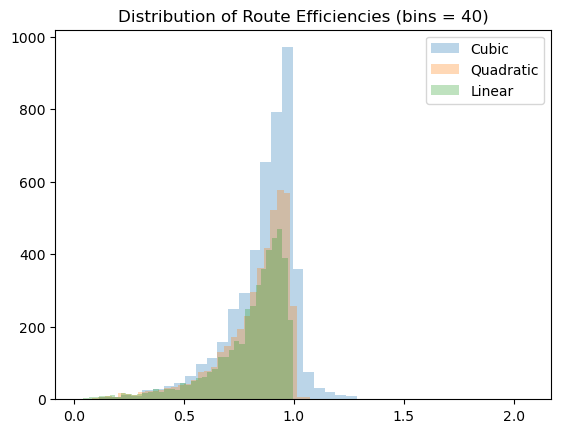

In [12]:
x1 = final[['c_route_efficiency']]
x2 = final[['q_route_efficiency']]
x3 = final[['route_efficiency']]

kwargs = dict(alpha=0.3, bins = 40)
plt.hist(x=x1, **kwargs, label = 'Cubic')
plt.hist(x=x2, **kwargs, label = 'Quadratic')
plt.hist(x=x3, **kwargs, label = 'Linear')
plt.legend()
plt.title('Distribution of Route Efficiencies (bins = 40)')
plt.show()

In [13]:
final.groupby('league')[['c_route_efficiency', 'q_route_efficiency', 'route_efficiency']].mean()

,c_route_efficiency,q_route_efficiency,route_efficiency
league,,,
Home1A,0.869192,0.827502,0.806323
Home2A,0.857429,0.815472,0.792834
Home3A,0.875290,0.833448,0.815799
Home4A,0.848656,0.810084,0.794447


In [14]:
final[final['player_id'] < 1000].groupby('player_id').agg(
    cubic_efficiency=('c_route_efficiency', 'mean'), 
    quadratic_efficiency=('q_route_efficiency', 'mean'),
    reg_route = ('route_efficiency', 'mean'),
    count=('at_bat', 'count'),
    league = ('league', 'first')
).sort_values(by='reg_route', ascending=False).head(10)


,cubic_efficiency,quadratic_efficiency,reg_route,count,league
player_id,,,,,
383.0,0.933452,0.903777,0.891687,13,Home4A
835.0,0.944920,0.920151,0.865049,1,Home4A
423.0,0.872692,0.865068,0.856352,8,Home1A
334.0,0.880369,0.874683,0.855153,2,Home3A
467.0,0.894366,0.864720,0.852433,30,Home4A
475.0,0.882825,0.850653,0.843348,129,Home3A
409.0,0.874709,0.850717,0.840921,13,Home4A
594.0,0.874146,0.842628,0.839221,37,Home1A
651.0,0.890702,0.850447,0.836625,135,Home2A


In [15]:
final.query('c_route_efficiency > 1.1').sort_values(by = 'c_route_efficiency')[['actual_distance', 'straight_line', 
                                                                                'quadratic_expected_distance', 'cubic_expected_distance', 
                                                                             'c_route_efficiency', 'q_route_efficiency', 'route_efficiency']]



,actual_distance,straight_line,quadratic_expected_distance,cubic_expected_distance,c_route_efficiency,q_route_efficiency,route_efficiency
86,67.038798,66.081976,66.595459,73.823165,1.101201,0.993387,0.985727
3746,43.204428,39.170613,40.897863,47.626540,1.102353,0.946613,0.906634
553,59.637383,57.370907,59.298229,65.756133,1.102599,0.994313,0.961996
639,94.747960,91.768028,99.415332,104.769141,1.105767,1.049261,0.968549
307,69.940898,64.171270,72.372577,77.348759,1.105916,1.034768,0.917507
...,...,...,...,...,...,...,...
3021,23.308699,20.838059,21.082163,37.699713,1.617410,0.904476,0.894004
809,29.836531,24.857342,25.781639,50.665717,1.698110,0.864096,0.833118
2825,19.304068,13.572168,17.390234,33.030150,1.711046,0.900859,0.703073
1068,8.710983,7.487987,10.663691,16.812478,1.930032,1.224166,0.859603


In [16]:
final['c_route_chng'] = final['c_route_efficiency'] - final['route_efficiency']
final['q_route_chng'] = final['q_route_efficiency'] - final['route_efficiency']

final.sort_values(by='q_route_chng', ascending = False)[['game_str', 'play_id',
                                                       'c_route_efficiency', 'q_route_efficiency', 
                                                         'route_efficiency', 
                                                       'c_route_chng', 'q_route_chng']].head(10)


,game_str,play_id,c_route_efficiency,q_route_efficiency,route_efficiency,c_route_chng,q_route_chng
3493,1884_107_Vis3AR_Home3A,43,1.215382,0.777828,0.075846,1.139536,0.701982
1733,1884_026_Vis2AH_Home2A,243,1.023981,1.000017,0.443551,0.580430,0.556466
2013,1884_037_Vis2AJ_Home2A,194,1.012308,1.002436,0.472077,0.540231,0.530359
2014,1884_037_Vis2AJ_Home2A,219,0.827915,0.833459,0.342727,0.485188,0.490731
2010,1884_037_Vis2AJ_Home2A,129,1.007973,1.010687,0.580765,0.427208,0.429923
2545,1884_062_Vis2AM_Home2A,204,1.034158,0.953423,0.530801,0.503357,0.422622
1397,1884_011_Vis2AF_Home2A,286,0.769371,0.676421,0.265650,0.503721,0.410771
2949,1884_082_Vis2AO_Home2A,19,0.657512,0.538428,0.154079,0.503433,0.384348
2238,1884_049_Vis1AQ_Home1A,119,1.017551,1.015991,0.650067,0.367484,0.365924
1068,1883_043_Vis3AF_Home3A,336,1.930032,1.224166,0.859603,1.070429,0.364563


In [17]:
final.describe()

,play_id,at_bat,play_per_game,end_time,almost_caught,start_time,inning,player_id,field_x,field_y,...,actual_time,handedness_encode,p1_y_pred,p2_y_pred,cubic_expected_distance,quadratic_expected_distance,c_route_efficiency,q_route_efficiency,c_route_chng,q_route_chng
count,4494.000000,4314.000000,4494.000000,4.494000e+03,4494.000000,4.494000e+03,4494.000000,3975.000000,4494.000000,4494.000000,...,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000,4494.000000
mean,142.790387,38.090867,143.972630,4.976326e+06,0.126168,4.971829e+06,4.641077,3133.340629,-0.116502,271.198753,...,4.496323,0.520694,270.951904,269.345947,60.938927,58.511416,0.862531,0.821581,0.060110,0.019160
std,86.128808,22.443098,86.783125,4.413941e+06,0.332076,4.413938e+06,2.656290,3082.873046,98.021608,30.189294,...,1.087647,0.499627,30.018034,37.694851,25.897797,25.842282,0.158736,0.164732,0.094248,0.049688
min,1.000000,0.000000,1.000000,1.087300e+04,0.000000,6.323000e+03,0.000000,334.000000,-174.922800,200.643000,...,2.150000,0.000000,204.719238,153.474503,4.488772,2.266018,0.115393,0.020969,-0.122730,-0.138583
25%,72.000000,19.000000,72.000000,2.305780e+06,0.000000,2.300630e+06,2.000000,537.000000,-113.557125,245.828175,...,3.600000,0.000000,246.062054,240.518970,41.092385,38.953971,0.796205,0.753440,0.010415,-0.002639
50%,137.000000,37.000000,138.000000,4.566242e+06,0.000000,4.561492e+06,5.000000,975.000000,-6.057450,261.989250,...,4.500000,1.000000,261.436844,268.297089,59.353300,57.271694,0.899668,0.871070,0.035581,0.010117
75%,210.750000,56.000000,212.000000,7.254698e+06,0.000000,7.251792e+06,7.000000,5419.000000,117.402825,301.015350,...,5.379000,1.000000,300.040611,298.583305,78.548594,76.078907,0.964250,0.939032,0.079123,0.032432
max,429.000000,106.000000,431.000000,8.749607e+07,1.000000,8.749202e+07,12.000000,9957.000000,176.677200,348.089400,...,7.750000,1.000000,333.848114,357.039581,158.921831,149.219666,2.068445,1.224166,1.535657,0.701982


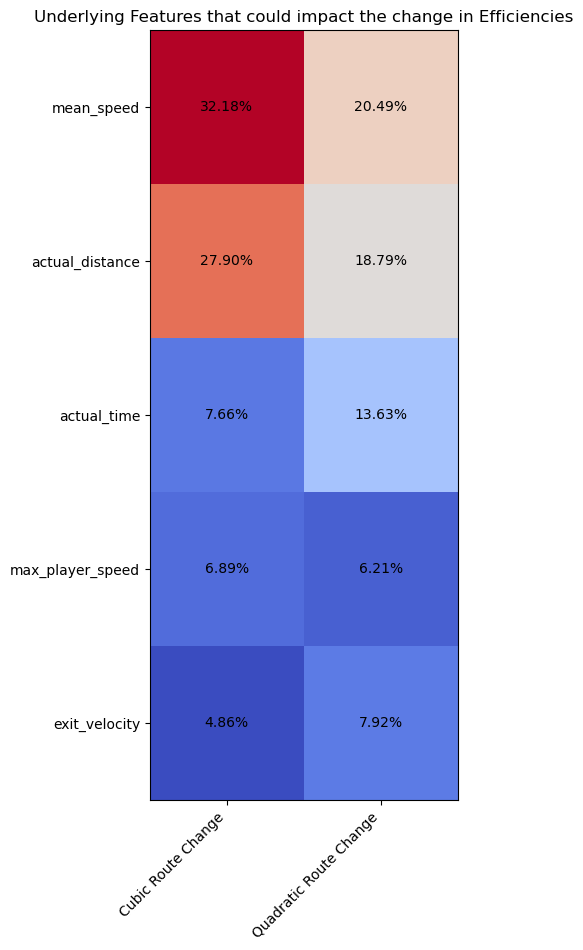

In [18]:
cols = ['inning', 'field_y', 'exit_velocity', 'launch_angle', 'actual_distance', 'mean_speed', 'p1_y', 'p2_y',
       'initial_angle', 'spray_angle',
       'max_player_speed', 'actual_time', 'handedness_encode', 'p1_y_pred', 'p2_y_pred',
       'c_route_chng','q_route_chng']

corr_matrix = final[cols].corr()

c_route_chng_corr = corr_matrix[['c_route_chng']].abs()
q_route_chng_corr = corr_matrix[['q_route_chng']].abs()

sorted_corr = ((pd.concat([c_route_chng_corr, q_route_chng_corr], axis=1).sort_values(by=['c_route_chng', 'q_route_chng'], ascending=False)
                .drop(['c_route_chng', 'q_route_chng'], axis = 0)) 
               * 100).head(5)

fig, ax = plt.subplots(figsize=(16, 10))
heatmap = ax.imshow(sorted_corr, cmap='coolwarm')
ax.set_xticks(np.arange(len(sorted_corr.columns)))
ax.set_yticks(np.arange(len(sorted_corr.index)))
ax.set_xticklabels(['Cubic Route Change', 'Quadratic Route Change'])
ax.set_yticklabels(sorted_corr.index)

plt.xticks(rotation=45, ha='right')

for i in range(len(sorted_corr.index)):
    for j in range(len(sorted_corr.columns)):
        text = ax.text(j, i, f'{sorted_corr.iloc[i, j]:.2f}%',
                       ha='center', va='center', color='black')
        
plt.title('Underlying Features that could impact the change in Efficiencies')
plt.show()

# Essentially, speed and distance are the features that are somewhat causing these corrections
# which is a good sign for the model.


# possibly show on paper

(0.0, 2.0)

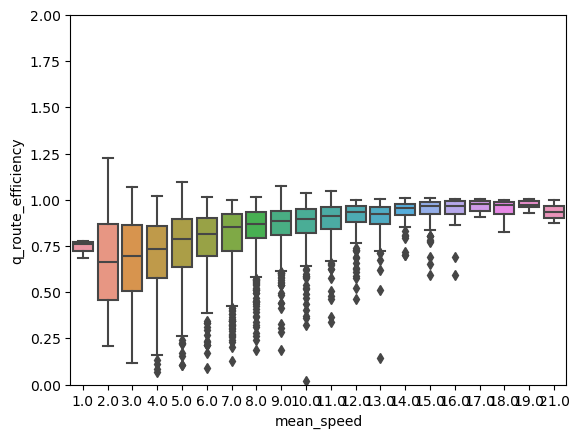

In [27]:
sns.boxplot(data = final, x = final['mean_speed'].round(0), y = 'q_route_efficiency')
plt.ylim(0, 2)

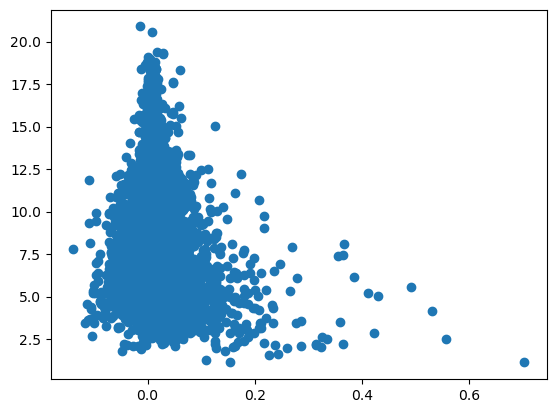

In [20]:
plt.scatter(final['q_route_chng'], final['mean_speed'])

# Catch Probability model
Initial angle works here. YAY!!!

Model will not include proximity to wall.

* Initial angle
* expected distance
* Actual time

In [21]:
final['is_caught'] = np.where((final['almost_caught'] == 0) & (final['event_code'] == 'Fielded'), 1, 0)
final.is_caught.mean()

0.8582554517133957

In [35]:
final.is_caught.sum()

3857

In [38]:
# Take a look at what features are correlated with this and multuply it to OAA.
final.groupby('player_id')['is_caught'].sum().sort_values(ascending=False).head()


player_id
651.0    118
495.0    116
963.0    113
475.0    108
492.0     98
Name: is_caught, dtype: int64

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, log_loss
from sklearn.calibration import calibration_curve


# use straight_line, cubic_expected_distance, quadratic_expected_distance
features = ['initial_angle', 'quadratic_expected_distance', 'actual_time']
X = final[features]
y = final['is_caught']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

model = LogisticRegression()

model.fit(X_train, y_train)

pred = model.predict_proba(X_test)[:,1]



In [29]:
pd.DataFrame({'features' : features, 'coefficients' : model.coef_[0]})


,features,coefficients
0,initial_angle,-0.000888
1,quadratic_expected_distance,-0.050016
2,actual_time,1.473384


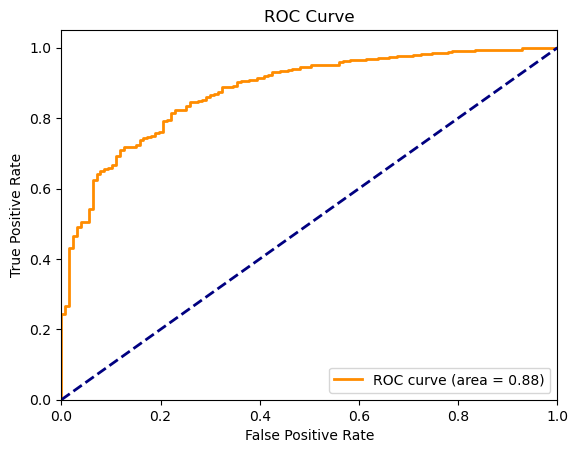

Log Loss: 0.27807607635656584


In [30]:
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print('Log Loss:', log_loss(y_test, pred))

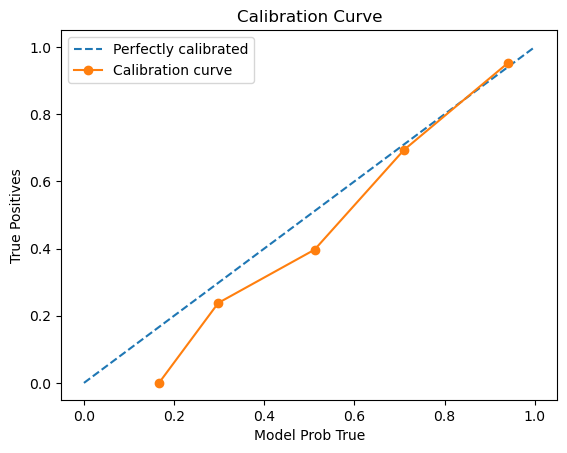

In [31]:
prob_true, prob_pred = calibration_curve(y_test.values, pred)

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')

plt.xlabel('Model Prob True')
plt.ylabel('True Positives')
plt.title('Calibration Curve')
plt.legend(loc = 'upper left')
plt.show()

In [32]:
final['catch_prob'] = model.predict_proba(final[features])[:, 1]

In [33]:
final['catch_prob'].describe()

count    4494.000000
mean        0.858740
std         0.165907
min         0.020025
25%         0.796026
50%         0.923511
75%         0.979990
max         0.999747
Name: catch_prob, dtype: float64

In [34]:
final

,game_str,play_id,at_bat,play_per_game,end_time,player_position,event_code,almost_caught,start_time,player_position_hit,...,p1_y_pred,p2_y_pred,cubic_expected_distance,quadratic_expected_distance,c_route_efficiency,q_route_efficiency,c_route_chng,q_route_chng,is_caught,catch_prob
0,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,0,67773,BA,...,307.340851,319.669586,23.387535,23.279352,0.560463,0.557871,0.006621,0.004028,1,0.997611
1,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,0,114723,BA,...,240.415726,215.724991,67.384952,65.828048,0.932447,0.910903,0.053099,0.031555,1,0.965413
2,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,0,1621073,BA,...,307.367798,276.698273,71.575377,71.458691,0.807418,0.806102,-0.024028,-0.025345,1,0.628247
3,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,0,1700073,BA,...,270.413025,288.862885,62.489751,62.457962,0.975942,0.975445,0.012255,0.011759,1,0.841255
4,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,0,2062623,BA,...,240.020920,264.587097,103.392230,103.200699,0.982500,0.980680,-0.003564,-0.005384,1,0.634600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4489,1884_142_Vis4BE_Home4A,226,60.0,227,8164459,LF,Fielded,1,8160659,BA,...,233.579620,228.573212,82.280565,78.787070,0.952803,0.912349,0.069684,0.029230,0,0.626079
4490,1884_142_Vis4BE_Home4A,227,61.0,228,8212309,RF,Fielded,0,8206859,BA,...,261.418884,281.564514,63.979744,63.878057,0.920528,0.919065,-0.000738,-0.002201,1,0.980695
4491,1884_142_Vis4BE_Home4A,232,63.0,234,8477309,CF,Fielded,0,8471509,BA,...,304.144592,313.857727,55.478833,54.384052,0.987860,0.968366,0.016800,-0.002694,1,0.990494
4492,1884_142_Vis4BE_Home4A,248,68.0,250,9170209,LF,Fielded,1,9167159,BA,...,257.659790,263.371521,46.799652,43.572066,1.025416,0.954697,0.080799,0.010080,0,0.764688
